<a href="https://colab.research.google.com/github/NehaKumari500092077/Deep-Learning-Lab/blob/main/Programming%20Assignment%204%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load dataset

In [ ]:
# Load the dataset
data = fetch_covtype()
X, y = data['data'], data['target'] - 1  # Shift target to 0-based index

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Define the network architecture

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, hidden_units=[128, 64], output_classes=7):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_features, hidden_units[0]),
            nn.ReLU(),
            nn.Linear(hidden_units[0], hidden_units[1]),
            nn.ReLU(),
            nn.Linear(hidden_units[1], output_classes)
        )

    def forward(self, x):
        return self.model(x)

#custom Adadelta implementation

In [ ]:
class CustomAdadelta:
    def __init__(self, parameters, lr=1.0, rho=0.9, epsilon=1e-6):
        self.parameters = list(parameters)
        self.lr = lr
        self.rho = rho
        self.epsilon = epsilon
        self.accumulated_grads = [torch.zeros_like(p.data,device=device) for p in self.parameters]
        self.accumulated_updates = [torch.zeros_like(p.data,device=device) for p in self.parameters]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.parameters):
                if p.grad is None:
                    continue
                grad = p.grad.data

                # Accumulate squared gradients
                self.accumulated_grads[i] = self.rho * self.accumulated_grads[i] + (1 - self.rho) * grad ** 2

                # Compute update
                update = grad * torch.sqrt(self.accumulated_updates[i] + self.epsilon) / torch.sqrt(
                    self.accumulated_grads[i] + self.epsilon
                )

                # Update parameters
                p.data -= self.lr * update

                # Accumulate squared updates
                self.accumulated_updates[i] = self.rho * self.accumulated_updates[i] + (1 - self.rho) * update ** 2

    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

# Custom NAG implementation

In [ ]:

class CustomNAG:
    def __init__(self, parameters, lr=0.01, momentum=0.9):
        self.parameters = list(parameters)  # Model parameters
        self.lr = lr
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p, device=p.device) for p in self.parameters]  # Initialize velocity

    def step(self, loss_fn, model, inputs, targets, optimizer):
        with torch.no_grad():  # Prevents tracking in autograd
            lookahead_params = [p - self.momentum * v for p, v in zip(self.parameters, self.velocity)]

        # Temporarily store original parameters
        original_params = [p.clone().detach() for p in self.parameters]

        with torch.no_grad():
            for p, new_p in zip(self.parameters, lookahead_params):
                p.copy_(new_p)  # Apply lookahead step

        # Compute gradient at lookahead position
        optimizer.zero_grad()  # Clear old gradients
        loss = loss_fn(model(inputs), targets)  # Compute loss at lookahead position
        loss.backward()  # Compute new gradients

        with torch.no_grad():
            for i, p in enumerate(self.parameters):
                if p.grad is None:
                    continue

                # Get the new gradient at lookahead position
                grad = p.grad.detach().clone()

                # Restore original parameter values
                p.copy_(original_params[i])

                # Update velocity using computed gradient
                self.velocity[i] = self.momentum * self.velocity[i] + self.lr * grad

                # Update parameters
                p.copy_(p - self.velocity[i])  # Safe update preserving computation graph

    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()


# Training And Evaluation

In [ ]:
def train_and_evaluate(model, optimizer, trainloader, valloader, testloader, criterion, epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(trainloader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs=inputs.to(device)
                labels=labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Test evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_labels.append(torch.argmax(labels, dim=1))

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = accuracy_score(all_labels.cpu(), all_preds.cpu())
    f1 = f1_score(all_labels.cpu(), all_preds.cpu(), average='weighted')

    return train_losses, val_losses, accuracy, f1


In [ ]:
def train_and_evaluate2(model, optimizer, trainloader, valloader, testloader, criterion, epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step(criterion, model,inputs,labels, optimizer)
            running_loss += loss.item()

        train_losses.append(running_loss / len(trainloader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs=inputs.to(device)
                labels=labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Test evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_labels.append(torch.argmax(labels, dim=1))

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = accuracy_score(all_labels.cpu(), all_preds.cpu())
    f1 = f1_score(all_labels.cpu(), all_preds.cpu(), average='weighted')

    return train_losses, val_losses, accuracy, f1


# Running The Experiments

In [ ]:
# Initialize the model
input_features = X_train.shape[1]
output_classes = y_train.shape[1]
model = NeuralNetwork(input_features, output_classes=output_classes).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Experiment 1: Custom NAG
optimizer_nag = CustomNAG(model.parameters(), lr=0.01, momentum=0.9)
train_losses_nag, val_losses_nag, test_accuracy_nag, test_f1_nag = train_and_evaluate2(
    model, optimizer_nag, trainloader, valloader, testloader, criterion
)

# Experiment 2: PyTorch's NAG
model = NeuralNetwork(input_features, output_classes=output_classes).to(device)  # Reset model
optimizer_torch_nag = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
train_losses_torch_nag, val_losses_torch_nag, test_accuracy_torch_nag, test_f1_torch_nag = train_and_evaluate(
    model, optimizer_torch_nag, trainloader, valloader, testloader, criterion
)

# Experiment 3: Custom Adadelta
model = NeuralNetwork(input_features, output_classes=output_classes).to(device)  # Reset model
optimizer_adadelta = CustomAdadelta(model.parameters())
train_losses_adadelta, val_losses_adadelta, test_accuracy_adadelta, test_f1_adadelta = train_and_evaluate(
    model, optimizer_adadelta, trainloader, valloader, testloader, criterion
)

# Experiment 4: PyTorch's Adadelta
model = NeuralNetwork(input_features, output_classes=output_classes).to(device)  # Reset model
optimizer_torch_adadelta = optim.Adadelta(model.parameters())
train_losses_torch_adadelta, val_losses_torch_adadelta, test_accuracy_torch_adadelta, test_f1_torch_adadelta = train_and_evaluate(
    model, optimizer_torch_adadelta, trainloader, valloader, testloader, criterion
)

# Print Results
print(f"Custom NAG: Accuracy={test_accuracy_nag:.4f}, F1={test_f1_nag:.4f}")
print(f"PyTorch NAG: Accuracy={test_accuracy_torch_nag:.4f}, F1={test_f1_torch_nag:.4f}")
print(f"Custom Adadelta: Accuracy={test_accuracy_adadelta:.4f}, F1={test_f1_adadelta:.4f}")
print(f"PyTorch Adadelta: Accuracy={test_accuracy_torch_adadelta:.4f}, F1={test_f1_torch_adadelta:.4f}")


Epoch 1/5, Train Loss: 0.5549, Val Loss: 0.4812
Epoch 2/5, Train Loss: 0.4418, Val Loss: 0.4168
Epoch 3/5, Train Loss: 0.3977, Val Loss: 0.4083
Epoch 4/5, Train Loss: 0.3718, Val Loss: 0.3652
Epoch 5/5, Train Loss: 0.3540, Val Loss: 0.3507
Epoch 1/5, Train Loss: 0.5553, Val Loss: 0.4986
Epoch 2/5, Train Loss: 0.4484, Val Loss: 0.4188
Epoch 3/5, Train Loss: 0.3986, Val Loss: 0.3752
Epoch 4/5, Train Loss: 0.3703, Val Loss: 0.3627
Epoch 5/5, Train Loss: 0.3503, Val Loss: 0.3411
Epoch 1/5, Train Loss: 0.5363, Val Loss: 0.4735
Epoch 2/5, Train Loss: 0.4595, Val Loss: 0.4477
Epoch 3/5, Train Loss: 0.4455, Val Loss: 0.4296
Epoch 4/5, Train Loss: 0.4354, Val Loss: 0.4248
Epoch 5/5, Train Loss: 0.4367, Val Loss: 0.4101
Epoch 1/5, Train Loss: 0.5301, Val Loss: 0.4742
Epoch 2/5, Train Loss: 0.4568, Val Loss: 0.4332
Epoch 3/5, Train Loss: 0.4407, Val Loss: 0.4313
Epoch 4/5, Train Loss: 0.4407, Val Loss: 0.4809
Epoch 5/5, Train Loss: 0.4396, Val Loss: 0.4171
Custom NAG: Accuracy=0.8539, F1=0.8532
P

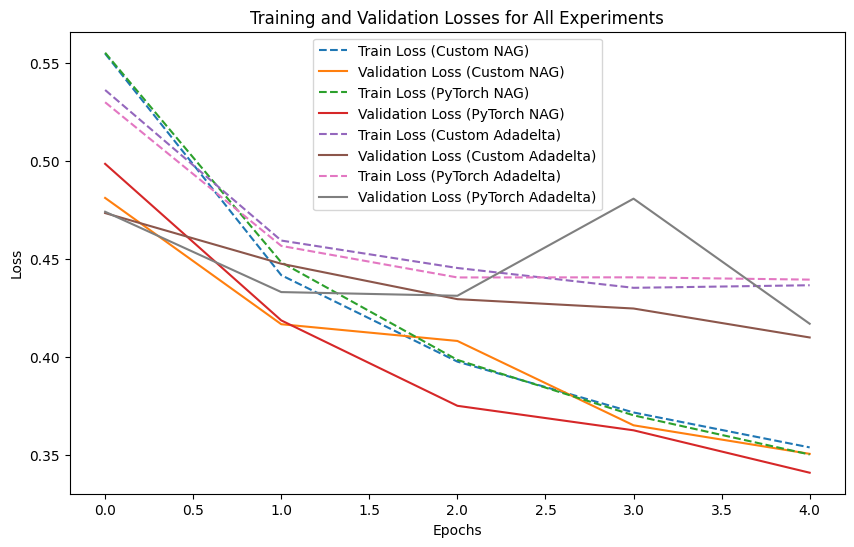

In [ ]:
# Plot the losses for all experiments
plt.figure(figsize=(10, 6))

# Plot Custom NAG losses
plt.plot(train_losses_nag, label="Train Loss (Custom NAG)", linestyle="--")
plt.plot(val_losses_nag, label="Validation Loss (Custom NAG)")

# Plot PyTorch NAG losses
plt.plot(train_losses_torch_nag, label="Train Loss (PyTorch NAG)", linestyle="--")
plt.plot(val_losses_torch_nag, label="Validation Loss (PyTorch NAG)")

# Plot Custom Adadelta losses
plt.plot(train_losses_adadelta, label="Train Loss (Custom Adadelta)", linestyle="--")
plt.plot(val_losses_adadelta, label="Validation Loss (Custom Adadelta)")

# Plot PyTorch Adadelta losses
plt.plot(train_losses_torch_adadelta, label="Train Loss (PyTorch Adadelta)", linestyle="--")
plt.plot(val_losses_torch_adadelta, label="Validation Loss (PyTorch Adadelta)")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Losses for All Experiments")
plt.show()
